# Evolving Pendulum Controllers
### [Last Update: July 2022][![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RobertTLange/gymnax/blob/main/examples/es_in_gymnax.ipynb)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

!pip install -q git+https://github.com/RobertTLange/gymnax.git@main
!pip install -q git+https://github.com/RobertTLange/evosax.git@main

## Open-ES with MLP Controller

In [1]:
import jax
import jax.numpy as jnp

from evosax import OpenES, ParameterReshaper, FitnessShaper, NetworkMapper
from evosax.utils import ESLog
from evosax.problems import GymFitness

rng = jax.random.PRNGKey(0)
network = NetworkMapper["MLP"](
    num_hidden_units=64,
    num_hidden_layers=2,
    num_output_units=2,
    hidden_activation="relu",
    output_activation="categorical",
)
pholder = jnp.zeros((4,))
params = network.init(
    rng,
    x=pholder,
    rng=rng,
)

param_reshaper = ParameterReshaper(params)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


ParameterReshaper: 4610 parameters detected for optimization.


In [3]:
strategy = OpenES(popsize=100,
                  num_dims=param_reshaper.total_params,
                  opt_name="sgd")
strategy.default_params

EvoParams(opt_params=OptParams(lrate_init=0.01, lrate_decay=0.999, lrate_limit=0.001, momentum=0.9, beta_1=None, beta_2=None, eps=None, max_speed=None), sigma_init=0.04, sigma_decay=0.999, sigma_limit=0.01, init_min=0.0, init_max=0.0, clip_min=-3.4028235e+38, clip_max=3.4028235e+38)

In [4]:
num_generations = 200
print_every_k_gens = 20

es_logging = ESLog(param_reshaper.total_params,
                   num_generations,
                   top_k=5,
                   maximize=True)
log = es_logging.initialize()

fit_shaper = FitnessShaper(centered_rank=True,
                           z_score=True,
                           w_decay=0.1,
                           maximize=True)

state = strategy.initialize(rng)

for gen in range(num_generations):
    rng, rng_init, rng_ask, rng_eval = jax.random.split(rng, 4)
    x, state = strategy.ask(rng_ask, state)
    reshaped_params = param_reshaper.reshape(x)
    fitness = evaluator.rollout(rng_eval, reshaped_params).mean(axis=1)
    fit_re = fit_shaper.apply(x, fitness)
    state = strategy.tell(x, fit_re, state)
    log = es_logging.update(log, x, fitness)
    
    if gen % print_every_k_gens == 0:
        print("Generation: ", gen, "Generation: ", log["log_top_1"][gen])

/Users/rob/anaconda3/envs/mle-toolbox/lib/python3.9/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


Generation:  0 Generation:  21.875
Generation:  20 Generation:  80.25
Generation:  40 Generation:  82.75
Generation:  60 Generation:  166.1875
Generation:  80 Generation:  200.0
Generation:  100 Generation:  200.0
Generation:  120 Generation:  200.0
Generation:  140 Generation:  200.0
Generation:  160 Generation:  200.0
Generation:  180 Generation:  200.0


(<Figure size 432x216 with 1 Axes>,
 <AxesSubplot:title={'center':'CartPole MLP OpenAI-ES'}, xlabel='Number of Generations', ylabel='Fitness Score'>)

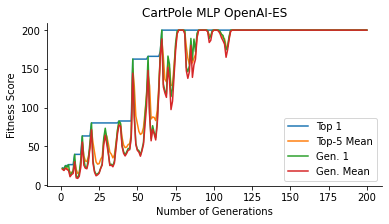

In [5]:
es_logging.plot(log, "CartPole MLP OpenAI-ES")

`evosax` also already comes equipped with a fitness rollout wrapper for all `gymnax` environments:

In [ ]:
evaluator = GymFitness("Acrobot-v1", num_env_steps=500, num_rollouts=16)
evaluator.set_apply_fn(param_reshaper.vmap_dict, network.apply)

## Evolving a Meta-LSTM to Control Different Length 2-Link Pendula